In [100]:
import openai
import requests
import json
import pandas as pd
from time import sleep
import os
from dotenv import load_dotenv

# --- LOAD ENVIRONMENT VARIABLES ---
load_dotenv()

N8N_WEBHOOK_URL = os.getenv("N8N_WEBHOOK_URL")
BENCHMARK_FILE = "education_agent_benchmark_real.jsonl"
openai.api_key = os.getenv("OPENAI_API_KEY")

if not N8N_WEBHOOK_URL or not openai.api_key:
    raise ValueError("Missing N8N_WEBHOOK_URL or OPENAI_API_KEY in .env file")

# --- 1. Load the Benchmark Test Cases ---

benchmark = []
with open(BENCHMARK_FILE, "r") as f:
    for line in f:
        benchmark.append(json.loads(line.strip()))

# --- 2. Function to Query the n8n Agent Webhook ---

def call_n8n_agent(user_query):
    payload = {
        "message": user_query,
        "from_agent": "testing_script",
    }
    response = requests.post(
        N8N_WEBHOOK_URL,
        json=payload,
        timeout=100
    )
    response.raise_for_status()
    result = response.json()
    # If n8n wraps output, extract 'output' field:
    #agent_output = result.get('output', result)  
    return result

# --- 3. Function to Call GPT-4.1 as a Judge ---

def score_with_gpt4o(user_query, agent_output, gold_standard_output, category):
    prompt = f"""
You are a rigorous, numeric-grading evaluator for a medical-education chatbot.

Below are:
• a **user query**  
• the **agent’s output**  
• a **gold-standard description** of what an ideal answer must contain  

### Scoring rubric  
Return **one float between 0.0 and 1.0** (inclusive) that best reflects how the agent’s answer matches the gold-standard requirements.

| Score | Meaning (give exactly this single value) |
|-------|------------------------------------------|
| **1.0** | Perfect – every required fact present; no forbidden or spurious info. |
| **0.9** | One very minor detail slightly off or missing. |
| **0.8** | A few small omissions / imprecisions, but core answer clearly correct. |
| **0.7** | About 70 % of key points correct; several gaps or mild inaccuracies. |
| **0.6** | Roughly half of required content present; notable missing pieces. |
| **0.5** | Mixed: some correct material, but about half wrong or absent. |
| **0.4** | Correct fragments exist, but majority missing / incorrect. |
| **0.3** | Only scattered correct facts; overall answer poor. |
| **0.2** | Largely incorrect; a couple of coincidental alignments at most. |
| **0.1** | Virtually no alignment with gold standard; answer mostly wrong. |
| **0.0** | Totally incorrect, off-topic, or hallucinates forbidden facts. |

*Ignore superficial formatting differences (bullets, headings, citation style) unless they alter substantive content.*

Return **only** the numeric score (e.g., `0.8`), nothing else.

────────────────────────────────────────
User Query:
{user_query}

Agent Output:
{agent_output}

Gold-Standard Output:
{gold_standard_output}
"""
    try:
        completion = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a rigorous evaluation assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10,
            temperature=0
        )
        raw = completion.choices[0].message.content
        score = float(raw.strip())
        if score > 1: score = 1.0
        if score < 0: score = 0.0
        return score
    except Exception as e:
        print(f"Error scoring with GPT-4o: {e}")
        return None


# --- 4. Run the Benchmark ---
results = []
for i, case in enumerate(benchmark):
    print(f"\nRunning test case {i+1}/{len(benchmark)}: {case['task_id']}")
    print(f"  User Query: {case['user_query']}")

    # 1. Call the agent
    try:
        agent_raw = call_n8n_agent(case["user_query"])
    except Exception as e:
        print(f"  Error calling agent: {e}")
        agent_raw = {"output": f"Error: {e}"}

    # 2. Select what the judge should see
    if case["category"] == "Referrals to Other Agents":
        llm_input = json.dumps(agent_raw)                 # full JSON for routing check
    else:
        llm_input = agent_raw.get("output", agent_raw)    # plain string for all others

    # 3. Score with GPT-4o
    try:
        score = score_with_gpt4o(
            case["user_query"],
            llm_input,
            case["gold_standard_output"],
            case["category"]
        )
        print(f"  Score: {score}")
    except Exception as e:
        print(f"  Error scoring: {e}")
        score = None

    # 4. Store results
    row = dict(case)
    row["agent_output"] = agent_raw                      # keep full output for audit
    row["score"] = score
    results.append(row)

    sleep(1)


Running test case 1/50: T1R-01
  User Query: At what age should female ATM heterozygotes generally begin breast-cancer surveillance with MRI according to current recommendations?
  Score: 0.9

Running test case 2/50: T1R-02
  User Query: List three cancers for which ATM heterozygotes have a clearly documented increased risk and provide the approximate odds ratio or relative-risk range given in the guideline.
  Score: 0.8

Running test case 3/50: T1R-03
  User Query: What stance does the ACMG practice resource take on using prophylactic mastectomy in unaffected ATM heterozygous women?
  Score: 0.8

Running test case 4/50: T1R-04
  User Query: According to the ACMG MPS II Delphi practice resource, when should enzyme-replacement therapy be started in a child aged six with severe Hunter syndrome who is already showing neurologic decline?
  Score: 0.5

Running test case 5/50: T1R-05
  User Query: Name two validated clinical tests the MPS II guideline recommends for routine functional follo

In [101]:
# --- 5. Save/Display Results in DataFrame ---

df_results_real_4o_4o = pd.DataFrame(results)
#df_results_4o_o1 = pd.DataFrame(results)
#df_results_o1_4o = pd.DataFrame(results)
#df_results_o1_o1 = pd.DataFrame(results)



In [102]:
df_results_real_4o_4o

# Average score per category
avg_score_per_category = df_results_real_4o_4o.groupby('category')['score'].mean()
print(avg_score_per_category)

category
Missing Information Handling    0.57
Multi-Source Synthesis          0.71
Tier 1 Retrieval                0.74
Tier 2 Retrieval                0.81
Wikipedia Fallback              0.26
Name: score, dtype: float64


In [98]:
df_results_o1_4o

# Average score per category
avg_score_per_category = df_results_o1_4o.groupby('category')['score'].mean()
print(avg_score_per_category)

category
Missing Information Handling    0.99
Multi-Source Synthesis          0.55
Referrals to Other Agents       0.85
Tier 1 Retrieval                0.60
Tier 2 Retrieval                0.48
Wikipedia Fallback              0.80
Name: score, dtype: float64


In [103]:
# 1. Add a column indicating the model config for each dataframe
df_results_real_4o_4o["model_config"] = "4o-4o"

# 3. Save to a file
df_results_real_4o_4o.to_csv("education_agent_benchmark_results_real.csv", index=False)

In [99]:
# 1. Add a column indicating the model config for each dataframe
df_results_4o_4o["model_config"] = "4o-4o"
df_results_o1_4o["model_config"] = "o1-4o"

# 2. Combine into a single dataframe
df_all_results_2 = pd.concat(
    [df_results_4o_4o,  df_results_o1_4o],
    ignore_index=True
)

# 3. Save to a file
df_all_results_2.to_csv("education_agent_benchmark_results_v3.csv", index=False)

In [34]:
df_results_4o_o1

avg_score_per_category = df_results_4o_o1.groupby('category')['score'].mean()
print(avg_score_per_category)

category
Missing Information Handling    0.75
Multi-Source Synthesis          0.60
Referrals to Other Agents       1.00
Tier 1 Retrieval                0.48
Tier 2 Retrieval                0.45
Wikipedia Fallback              0.80
Name: score, dtype: float64


In [35]:
df_results_o1_4o

avg_score_per_category = df_results_o1_4o.groupby('category')['score'].mean()
print(avg_score_per_category)

category
Missing Information Handling    0.70
Multi-Source Synthesis          0.35
Referrals to Other Agents       1.00
Tier 1 Retrieval                0.44
Tier 2 Retrieval                0.23
Wikipedia Fallback              0.90
Name: score, dtype: float64


In [36]:
df_results_o1_o1

avg_score_per_category = df_results_o1_o1.groupby('category')['score'].mean()
print(avg_score_per_category)

category
Missing Information Handling    0.68
Multi-Source Synthesis          0.30
Referrals to Other Agents       1.00
Tier 1 Retrieval                0.51
Tier 2 Retrieval                0.32
Wikipedia Fallback              0.99
Name: score, dtype: float64


In [37]:
# 1. Add a column indicating the model config for each dataframe
df_results_4o_4o["model_config"] = "4o-4o"
df_results_4o_o1["model_config"] = "4o-o1"
df_results_o1_4o["model_config"] = "o1-4o"
df_results_o1_o1["model_config"] = "o1-o1"

# 2. Combine into a single dataframe
df_all_results = pd.concat(
    [df_results_4o_4o, df_results_4o_o1, df_results_o1_4o, df_results_o1_o1],
    ignore_index=True
)

# 3. Save to a file
df_all_results.to_csv("education_agent_benchmark_results.csv", index=False)


In [40]:
# Group by model_config and category, then take the mean of 'score'
category_means = df_all_results.groupby(['model_config', 'category'])['score'].mean().reset_index()
print(category_means)

   model_config                      category  score
0         4o-4o  Missing Information Handling   0.80
1         4o-4o        Multi-Source Synthesis   0.46
2         4o-4o     Referrals to Other Agents   1.00
3         4o-4o              Tier 1 Retrieval   0.49
4         4o-4o              Tier 2 Retrieval   0.33
5         4o-4o            Wikipedia Fallback   0.92
6         4o-o1  Missing Information Handling   0.75
7         4o-o1        Multi-Source Synthesis   0.60
8         4o-o1     Referrals to Other Agents   1.00
9         4o-o1              Tier 1 Retrieval   0.48
10        4o-o1              Tier 2 Retrieval   0.45
11        4o-o1            Wikipedia Fallback   0.80
12        o1-4o  Missing Information Handling   0.70
13        o1-4o        Multi-Source Synthesis   0.35
14        o1-4o     Referrals to Other Agents   1.00
15        o1-4o              Tier 1 Retrieval   0.44
16        o1-4o              Tier 2 Retrieval   0.23
17        o1-4o            Wikipedia Fallback 

In [41]:
# Group by model_config, then take the mean of 'score'
model_config_means = df_all_results.groupby('model_config')['score'].mean().reset_index()
print(model_config_means)

  model_config     score
0        4o-4o  0.666667
1        4o-o1  0.680000
2        o1-4o  0.603333
3        o1-o1  0.633333


In [42]:
# Pivot table for average score per category per model config
pivot_category = category_means.pivot(index='category', columns='model_config', values='score')
print(pivot_category)

# Pivot table for average score per model config (single row)
pivot_model = model_config_means.set_index('model_config').T
print(pivot_model)

model_config                  4o-4o  4o-o1  o1-4o  o1-o1
category                                                
Missing Information Handling   0.80   0.75   0.70   0.68
Multi-Source Synthesis         0.46   0.60   0.35   0.30
Referrals to Other Agents      1.00   1.00   1.00   1.00
Tier 1 Retrieval               0.49   0.48   0.44   0.51
Tier 2 Retrieval               0.33   0.45   0.23   0.32
Wikipedia Fallback             0.92   0.80   0.90   0.99
model_config     4o-4o  4o-o1     o1-4o     o1-o1
score         0.666667   0.68  0.603333  0.633333


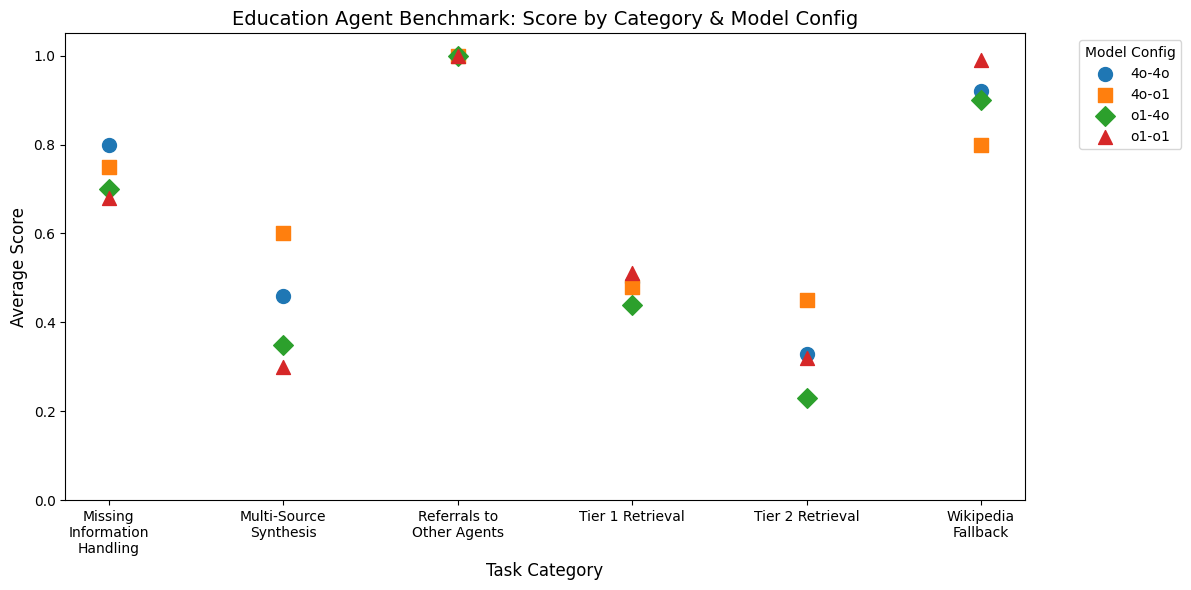

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Get average score per category per model_config
df_avg = (
    df_all_results
    .groupby(['category', 'model_config'])['score']
    .mean()
    .reset_index()
)

# Define unique categories and model configs
categories = df_avg['category'].unique()
model_configs = df_avg['model_config'].unique()

# To ensure consistent x order
cat_order = list(categories)
df_avg['category'] = pd.Categorical(df_avg['category'], categories=cat_order, ordered=True)
df_avg = df_avg.sort_values(['category', 'model_config'])

# Marker and color options for up to 4 configs
markers = ['o', 's', 'D', '^']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(figsize=(12, 6))

for i, model in enumerate(model_configs):
    data = df_avg[df_avg['model_config'] == model]
    # x positions are indices of categories
    x_pos = [cat_order.index(cat) for cat in data['category']]
    ax.scatter(
        x_pos, data['score'],
        label=model,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        s=100  # dot size
    )

# Set x-axis labels and wrap long labels
def wrap_labels(labels, width=16):
    return ['\n'.join(textwrap.wrap(l, width)) for l in labels]

ax.set_xticks(range(len(cat_order)))
ax.set_xticklabels(wrap_labels(cat_order), rotation=0, ha='center')

ax.set_xlabel("Task Category", fontsize=12)
ax.set_ylabel("Average Score", fontsize=12)
ax.set_title("Education Agent Benchmark: Score by Category & Model Config", fontsize=14)
ax.set_ylim(0, 1.05)
ax.legend(title="Model Config", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/yj/8cdmv5hs1vd_lccxvxwrzx9m0000gn/T/ipykernel_69947/3165659986.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby(["category", "model_config"])["score"]


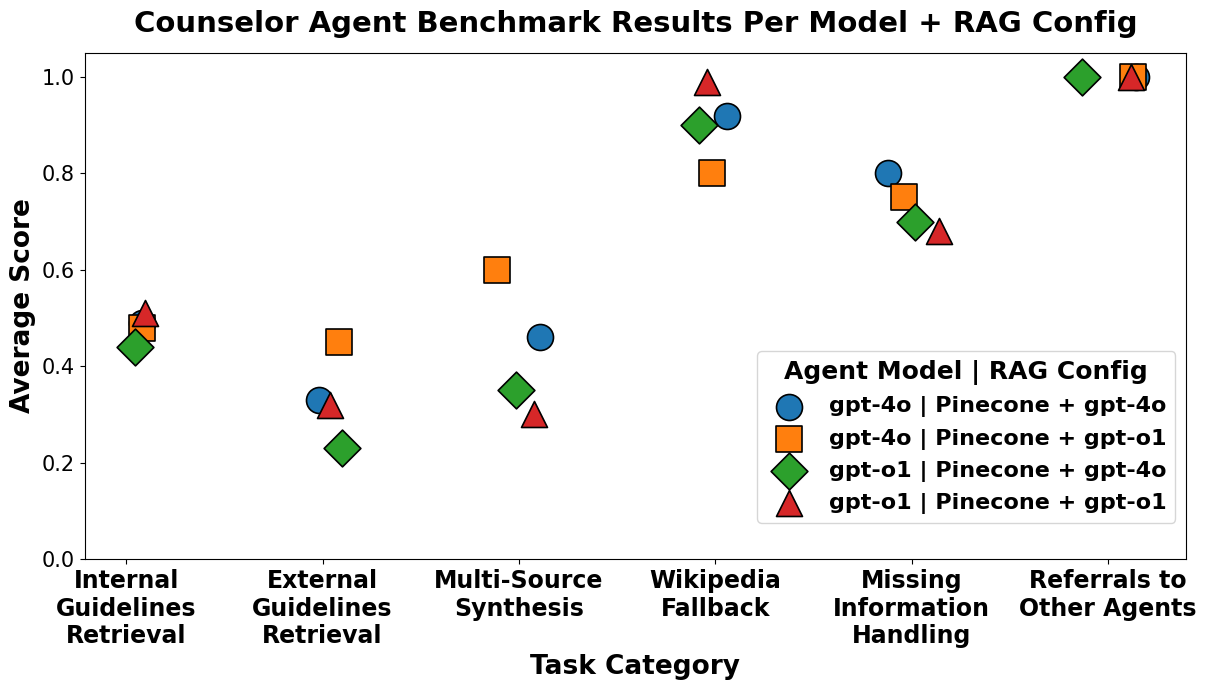

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# -----------------------------------------------------------
#  Assumes df_all_results already exists and has columns:
#      category   score   model_config
#  model_config values should be '4o-4o', '4o-o1', 'o1-4o', 'o1-o1'
# -----------------------------------------------------------

# 1.  Rename Tier categories
rename_map = {
    "Tier 1 Retrieval": "Internal Guidelines Retrieval",
    "Tier 2 Retrieval": "External Guidelines Retrieval",
}
df_plot = df_all_results.replace({"category": rename_map})

# 2.  Desired category order
cat_order = [
    "Internal Guidelines Retrieval",
    "External Guidelines Retrieval",
    "Multi-Source Synthesis",
    "Wikipedia Fallback",
    "Missing Information Handling",
    "Referrals to Other Agents"
]
df_plot["category"] = pd.Categorical(df_plot["category"], categories=cat_order, ordered=True)

#  -- Average score per (category, model_config)
df_avg = (
    df_plot.groupby(["category", "model_config"])["score"]
           .mean()
           .reset_index()
           .dropna(subset=["score"])
)

# 4.  Pretty legend labels
legend_labels = {
    "4o-4o": "gpt-4o | Pinecone + gpt-4o",
    "4o-o1": "gpt-4o | Pinecone + gpt-o1",
    "o1-4o": "gpt-o1 | Pinecone + gpt-4o",
    "o1-o1": "gpt-o1 | Pinecone + gpt-o1",
}

#  Marker & color palette (length 4)
markers = ["o", "s", "D", "^"]
colors  = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# 5.  Horizontal jitter strength
jitter = 0.15
rng = np.random.default_rng(42)

fig, ax = plt.subplots(figsize=(14, 7))

for idx, (config, label) in enumerate(legend_labels.items()):
    sub = df_avg[df_avg["model_config"] == config]
    if sub.empty:
        continue
    x_base = np.array([cat_order.index(c) for c in sub["category"]])
    x_jitter = x_base + rng.uniform(-jitter, jitter, size=len(x_base))
    
    ax.scatter(
        x_jitter,
        sub["score"],
        s=350,                              # 6. Larger dots
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        edgecolor="black",
        linewidth=1.2,
        label=label
    )

# 3.  Legend bottom-right, bigger & bold
leg = ax.legend(
    title="Agent Model | RAG Config",
    loc="lower right",
    bbox_to_anchor=(1.0, 0.05),
    fontsize=16,
    title_fontsize=18,
    frameon=True
)
plt.setp(leg.get_title(), fontweight="bold")
for txt in leg.get_texts():
    txt.set_fontweight("bold")

# 7.  Axis labels & title (bold, bigger) + wrapped x-tick labels
def wrap(txt, width=16):
    return "\n".join(textwrap.wrap(txt, width))

ax.set_xticks(range(len(cat_order)))
ax.set_xticklabels([wrap(c) for c in cat_order], fontsize=17, fontweight="bold")
ax.set_xlabel("Task Category", fontsize=19, fontweight="bold")
ax.set_ylabel("Average Score", fontsize=19, fontweight="bold")
ax.set_title("Counselor Agent Benchmark Results Per Model + RAG Config",
             fontsize=21, fontweight="bold", pad=15)

ax.tick_params(axis="y", labelsize=15)
ax.set_ylim(0, 1.05)

plt.tight_layout(rect=[0, 0, 0.87, 1])  # leave space for legend
plt.show()

/var/folders/yj/8cdmv5hs1vd_lccxvxwrzx9m0000gn/T/ipykernel_69947/1624315970.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby(["category", "model_config"])["score"]


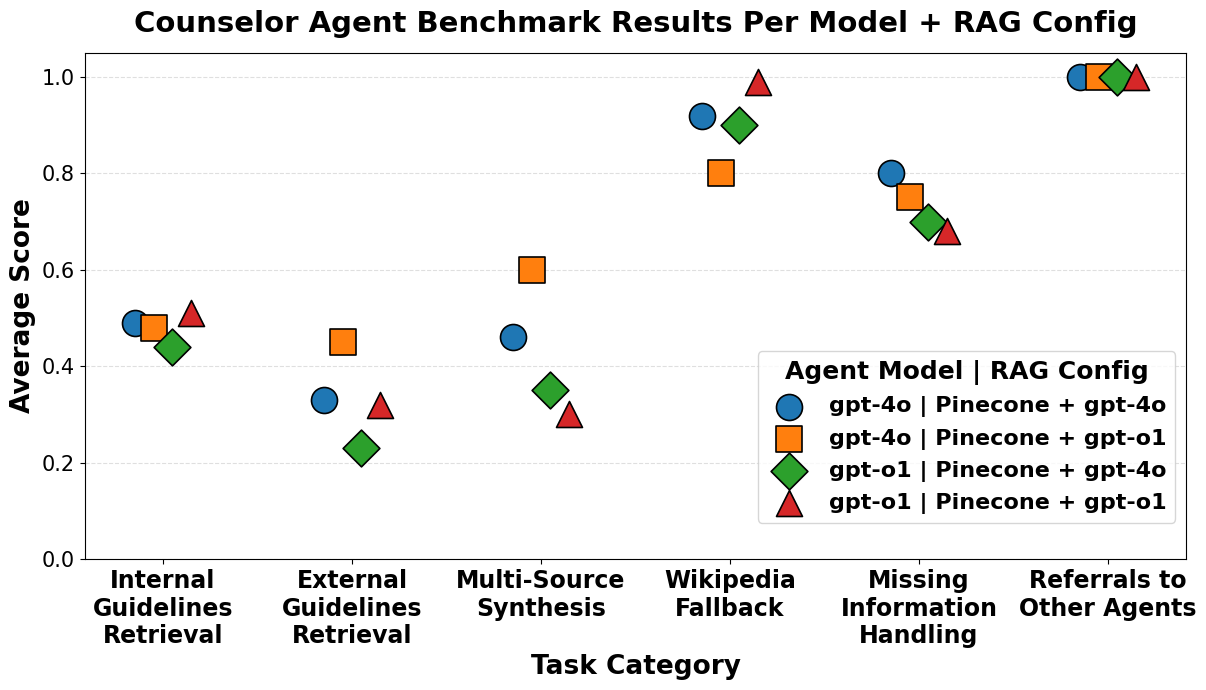

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# -----------------------------------------------------------
#  Assumes df_all_results already exists and has columns:
#      category   score   model_config
# -----------------------------------------------------------

# 1. Rename Tier categories
rename_map = {
    "Tier 1 Retrieval": "Internal Guidelines Retrieval",
    "Tier 2 Retrieval": "External Guidelines Retrieval",
}
df_plot = df_all_results.replace({"category": rename_map})

# 2. Desired category order
cat_order = [
    "Internal Guidelines Retrieval",
    "External Guidelines Retrieval",
    "Multi-Source Synthesis",
    "Wikipedia Fallback",
    "Missing Information Handling",
    "Referrals to Other Agents",
]
df_plot["category"] = pd.Categorical(
    df_plot["category"], categories=cat_order, ordered=True
)

# 3. Average score per (category, model_config)
df_avg = (
    df_plot.groupby(["category", "model_config"])["score"]
    .mean()
    .reset_index()
    .dropna(subset=["score"])
)

# 4. Legend labels
legend_labels = {
    "4o-4o": "gpt-4o | Pinecone + gpt-4o",
    "4o-o1": "gpt-4o | Pinecone + gpt-o1",
    "o1-4o": "gpt-o1 | Pinecone + gpt-4o",
    "o1-o1": "gpt-o1 | Pinecone + gpt-o1",
}

# 5. Marker & color palette
markers = ["o", "s", "D", "^"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# --------  FIXED jitter per model_config  --------
offset_map = {             # left … center … right
    "4o-4o": -0.15,
    "4o-o1": -0.05,
    "o1-4o":  0.05,
    "o1-o1":  0.15,
}

fig, ax = plt.subplots(figsize=(14, 7))

for idx, (config, label) in enumerate(legend_labels.items()):
    sub = df_avg[df_avg["model_config"] == config]
    if sub.empty:
        continue
    x_center = np.array([cat_order.index(c) for c in sub["category"]], dtype=float)
    x_plot   = x_center + offset_map[config]          # << fixed offset here

    ax.scatter(
        x_plot,
        sub["score"],
        s=350,
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        edgecolor="black",
        linewidth=1.2,
        label=label,
        zorder=3
    )

# Grid for readability
ax.yaxis.grid(True, linestyle="--", alpha=0.4, zorder=0)

# Legend (bottom-right)
leg = ax.legend(
    title="Agent Model | RAG Config",
    loc="lower right",
    bbox_to_anchor=(1.00, 0.05),
    fontsize=16,
    title_fontsize=18,
    frameon=True,
)
plt.setp(leg.get_title(), fontweight="bold")
for txt in leg.get_texts():
    txt.set_fontweight("bold")

# Axis labels / title
def wrap(txt, width=16):
    return "\n".join(textwrap.wrap(txt, width))

ax.set_xticks(range(len(cat_order)))
ax.set_xticklabels([wrap(c) for c in cat_order], fontsize=17, fontweight="bold")
ax.set_xlabel("Task Category", fontsize=19, fontweight="bold")
ax.set_ylabel("Average Score", fontsize=19, fontweight="bold")
ax.set_title(
    "Counselor Agent Benchmark Results Per Model + RAG Config",
    fontsize=21,
    fontweight="bold",
    pad=15,
)

ax.tick_params(axis="y", labelsize=15)
ax.set_ylim(0, 1.05)

plt.tight_layout(rect=[0, 0, 0.87, 1])
plt.show()
